<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Analyzing_Confocal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
javabridge.start_vm(class_path=bioformats.JARS)

In [41]:
# !wget -O 'image.oir' 'https://www.dropbox.com/s/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/8yiynglvcfww3cd/RNF182_08-12-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'
!wget -O 'image.oir' 'https://www.dropbox.com/s/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/tf88caoqox1z765/Nell2_08-04-22_S001_CA3_40X_2XZOOM_7.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'

--2022-09-26 22:42:42--  https://www.dropbox.com/s/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir [following]
--2022-09-26 22:42:43--  https://www.dropbox.com/s/raw/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc10de2c2a85941e9e8e4d013fc8.dl.dropboxusercontent.com/cd/0/inline/Bts_EfzFd0ug8JWMEvxH3XNArszjhQYTLN-0fZnmb0sBKhu9VsGt3x8NCO1OTdYCUfiC7Px2jtNxqJUhH_guqnkZvFvT5iRu1vT0J5p96gtbwTSiPWvu6bStI2YDkxyaL3YhdedpKDcnexkEFfZfew0Ojvwhx9Xy_gWPTvIHVft3Jg/file# [following]
--2022-09-26 22:42:43--  https://uc10de2c2a85941e9e8e4d013fc8.dl.dropboxusercontent.com/cd/0/i

In [42]:
my_reader = bioformats.get_image_reader('my_image', 'image.oir')

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 8
(800, 800, 3, 8)


In [43]:
def new_colormap(start,stop,n=256):
    start = np.array(start)
    stop = np.array(stop)
    delta_ni = np.expand_dims((stop-start)/n,-1)
    ni = np.expand_dims(np.arange(n),-1)
    cmap_np = start + np.multiply(delta_ni.T,ni)
    return matplotlib.colors.ListedColormap(cmap_np)


green_map = new_colormap([0,0,0,1],[0,1,0,1])
red_map = new_colormap([0,0,0,1],[1,0,0,1])
white_map = new_colormap([0,0,0,1],[1,1,1,1])
blue_map = new_colormap([0,0,0,1],[0,0,1,1])

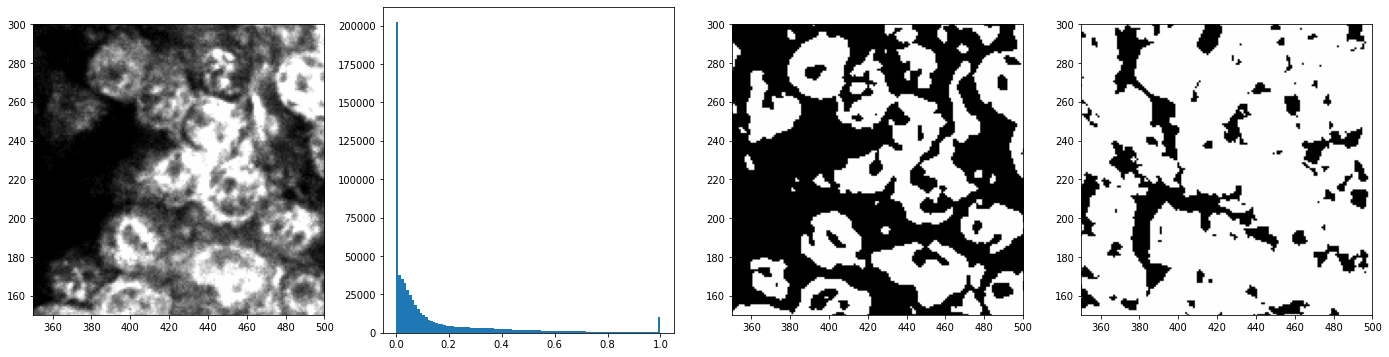

In [170]:
####################### Process NEUN
neun_im = image[:,:,2,:]
m_size = 2
g_sigma_1 = 1
g_sigma_2 = 10
im_filtered = neun_im.copy()
im_binary= im_filtered.copy()
for zi in range(neun_im.shape[-1]):
    im_zi = neun_im[:,:,zi]
    im_zi_mf = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    im_zi_gf = ciim_F = skimage.filters.gaussian(im_zi_mf, sigma = g_sigma_1)   #### blur
    im_zi_bk = ciim_F = skimage.filters.gaussian(im_zi_gf, sigma = g_sigma_2)  ### get background from big blur
    im_zi_bs = im_zi_gf - im_zi_bk
    im_filtered[:,:,zi] = im_zi_bs
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())*.01

neun_im_f = im_filtered
neu_mask_z = im_binary
neu_mask_zp = np.max(neu_mask_z,axis=-1)


sp=5
fig,ax = plt.subplots(1,4,figsize=[24,6])
ax[0].imshow(neun_im[:,:,sp],cmap=white_map)
ax[1].hist(neun_im[:,:,sp].flatten(),100)
ax[2].imshow(neu_mask_z[:,:,sp],cmap=white_map)
ax[3].imshow(neu_mask_zp,cmap=white_map)


for ai in ax[[0, 2, 3]]:
    ai.set_xlim(350,500)
    ai.set_ylim(150,300)
plt.show()

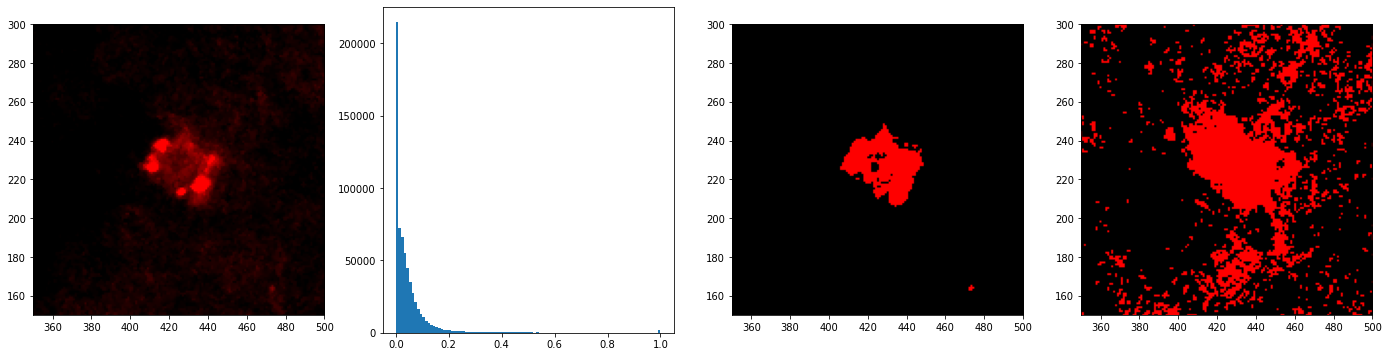

In [141]:
####################### Process mcherry
mcherry_im = image[:,:,1,:]
m_size = 2
g_sigma_1 = 2
g_sigma_2 = 10
im_filtered = mcherry_im.copy()
im_binary = np.zeros_like(im_filtered)
for zi in range(neun_im.shape[-1]):
    im_zi = mcherry_im[:,:,zi]
    im_zi_mf = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    # im_zi_gf = ciim_F = skimage.filters.gaussian(im_zi_mf, sigma = g_sigma_1)   #### blur
    # im_zi_bk = ciim_F = skimage.filters.gaussian(im_zi_gf, sigma = g_sigma_2)  ### get background from big blur
    # im_zi_bs = im_zi_gf - im_zi_bk
    im_filtered[:,:,zi] = im_zi_mf
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())



mcherry_im_f = im_filtered
mcherry_mazk_z = im_binary
mcherry_mask_zp = np.max(mcherry_mazk_z,axis=-1)

zi = 5
fig,ax = plt.subplots(1,4,figsize=[24,6])
ax[0].imshow(mcherry_im_f[:,:,sp],cmap=red_map)
ax[1].hist(mcherry_im_f[:,:,sp].flatten(),100)
ax[2].imshow(mcherry_mazk_z[:,:,sp],cmap=red_map)
ax[3].imshow(mcherry_mask_zp,cmap=red_map)


for ai in ax[[0, 2, 3]]:
    ai.set_xlim(350,500)
    ai.set_ylim(150,300)
plt.show()

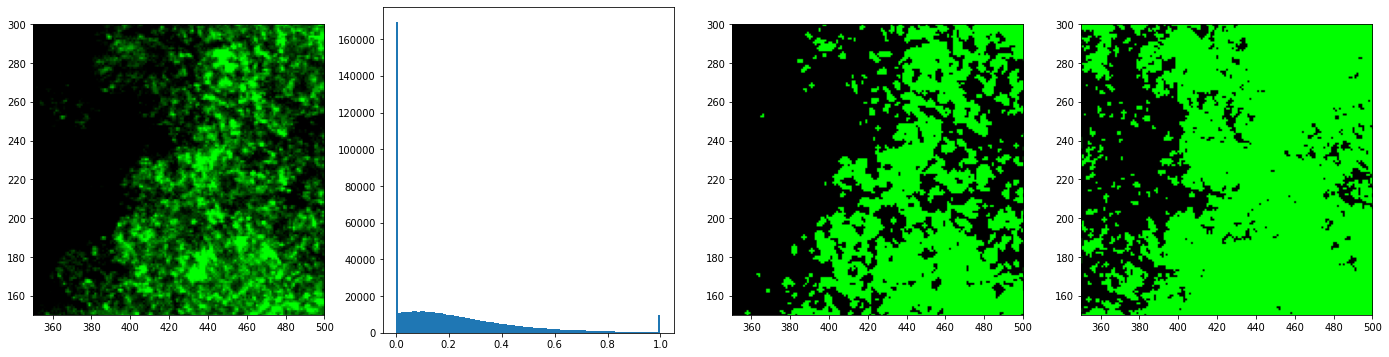

In [142]:
####################### Process CrispTarg
target_im = image[:,:,0,:]
m_size = 2
g_sigma_1 = 2
g_sigma_2 = 10
im_filtered = target_im.copy()
im_binary = np.zeros_like(im_filtered)
for zi in range(target_im.shape[-1]):
    im_zi = target_im[:,:,zi]
    im_zi_mf = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    # im_zi_gf = ciim_F = skimage.filters.gaussian(im_zi_mf, sigma = g_sigma_1)   #### blur
    # im_zi_bk = ciim_F = skimage.filters.gaussian(im_zi_gf, sigma = g_sigma_2)  ### get background from big blur
    # im_zi_bs = im_zi_gf - im_zi_bk
    # im_zi_bs = im_zi_bs - np.min(im_zi_bs.flatten())
    im_filtered[:,:,zi] = im_zi_mf
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())

target_im_f = im_filtered
target_mazk_z = im_binary
target_mask_zp = np.max(im_binary,axis=-1)
zi = 5
fig,ax = plt.subplots(1,4,figsize=[24,6])
ax[0].imshow(target_im[:,:,sp],cmap=green_map)
ax[1].hist(target_im[:,:,sp].flatten(),100)
ax[2].imshow(target_mazk_z[:,:,sp],cmap=green_map)
ax[3].imshow(target_mask_zp,cmap=green_map)


for ai in ax[[0, 2, 3]]:
    ai.set_xlim(350,500)
    ai.set_ylim(150,300)
plt.show()

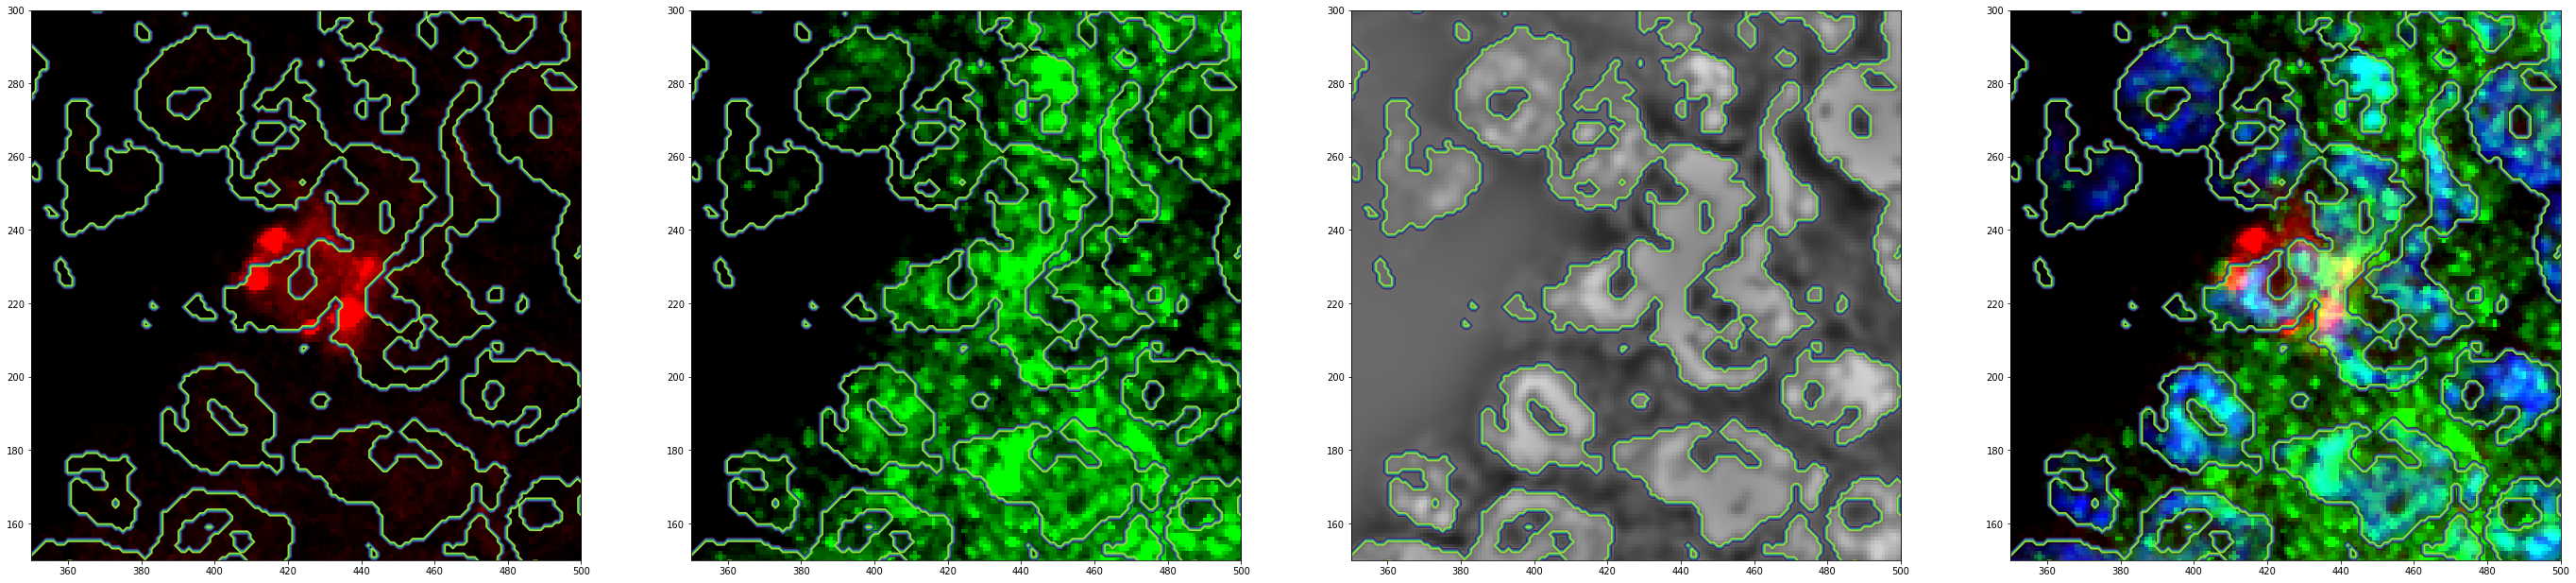

In [181]:
size = 12
fig,ax = plt.subplots(1,4,figsize=[4*size,size])
ax = ax.flatten()

# neu_mask_zp_3 = np.expand_dims(neu_mask,-1)
n_mask = neu_mask_z
# n_mask = np.ones_like(neu_mask_z)
neuronal_mcherry = mcherry_im_f
neuronal_target = target_im_f
neuronal_neun = neun_im_f

neuronal_mcherry = neuronal_mcherry/np.max(neuronal_mcherry.flatten())
neuronal_target = neuronal_target/np.max(neuronal_target.flatten())
neuronal_neun = neuronal_neun/np.max(neuronal_neun.flatten())*2

composite = np.stack([neuronal_mcherry,neuronal_target,neuronal_neun],axis=-2)*1.0

sp = 5
ax[0].imshow(composite[:,:,0,sp],cmap=red_map)
ax[1].imshow(composite[:,:,1,sp],cmap=green_map)
ax[2].imshow(composite[:,:,2,sp],cmap=white_map)
ax[3].imshow(composite[:,:,:,sp])


for ai in ax:
    ai.set_xlim(350,500)
    ai.set_ylim(150,300)
    ai.contour(n_mask[:,:,sp])
plt.show()


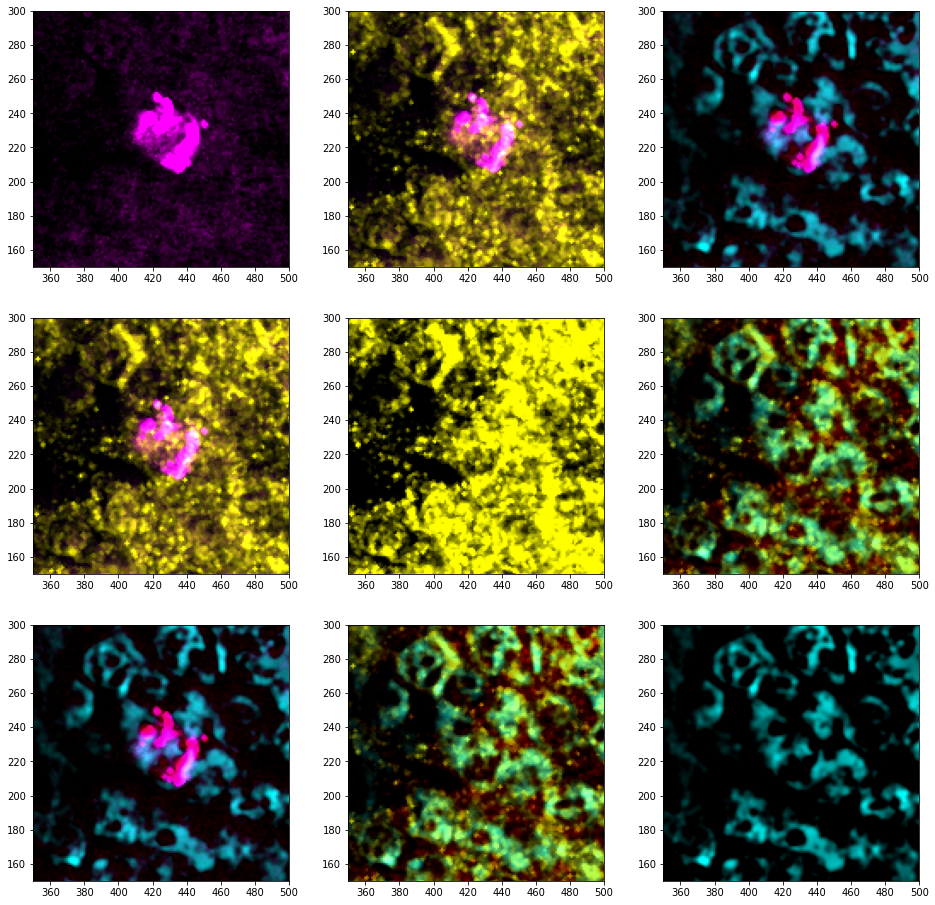

In [167]:
blanks = np.zeros_like(neuronal_mcherry)
neuronal_mcherry_rgb = np.stack([ neuronal_mcherry, blanks, blanks],axis = -2)
neuronal_target_rgb = np.stack([blanks, neuronal_target, blanks ],axis = -2)
neuronal_neun_rgb = np.stack([blanks, blanks, neuronal_neun ],axis = -2)

im_list = [neuronal_mcherry_rgb, neuronal_target_rgb, neuronal_neun_rgb]

fig,ax =plt.subplots(3,3,figsize = [16,16])
for im_i in range(len(im_list)):
    for im_i2 in range(len(im_list)):
        im_merge = im_list[im_i] + im_list[im_i2]
        im_merge = rgb_cmy(im_merge)*2
        ax[im_i,im_i2].imshow(im_merge[:,:,:,sp])


for ai in ax.flatten():
    ai.set_xlim(350,500)
    ai.set_ylim(150,300)
plt.show()

In [150]:

def rgb_cmy(image,caxis=2,balance = [1,1,1]):

    image = np.moveaxis(image, caxis, 2)

    image_R = image[:,:,0]
    image_G = image[:,:,1]
    image_B = image[:,:,2]


    CYM_r = np.zeros_like(image)
    CYM_r[:,:,0] = image_R
    CYM_r[:,:,2] = image_R

    CYM_g = np.zeros_like(image)
    CYM_g[:,:,0] = image_G
    CYM_g[:,:,1] = image_G

    CYM_b = np.zeros_like(image)
    CYM_b[:,:,1] = image_B
    CYM_b[:,:,2] = image_B

    merge_cym = CYM_r*balance[0] + CYM_g*balance[1] + CYM_b*balance[2]
    merge_cym = merge_cym/np.max(merge_cym)
    return merge_cym

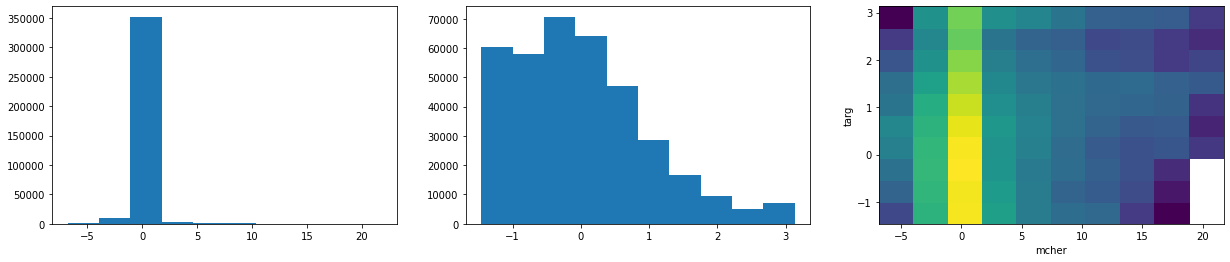

In [48]:
import matplotlib as mpl

is_neuron = neu_mask_3d.flatten()>0
neuronal_mcherry_vals = mcherry_im.flatten()[is_neuron]
neuronal_target_vals = target_im.flatten()[is_neuron]
neuronal_mcherry_vals = (neuronal_mcherry_vals-np.mean(neuronal_mcherry_vals))/np.std(neuronal_mcherry_vals)
neuronal_target_vals = (neuronal_target_vals-np.mean(neuronal_target_vals))/np.std(neuronal_target_vals)
fig, ax = plt.subplots(1,3,figsize=[21,4])
ax[0].hist(neuronal_mcherry_vals)
ax[1].hist(neuronal_target_vals)
ax[2].hist2d(neuronal_mcherry_vals,neuronal_target_vals,norm=mpl.colors.LogNorm())
ax[2].set_xlabel('mcher')
ax[2].set_ylabel('targ')
plt.show()


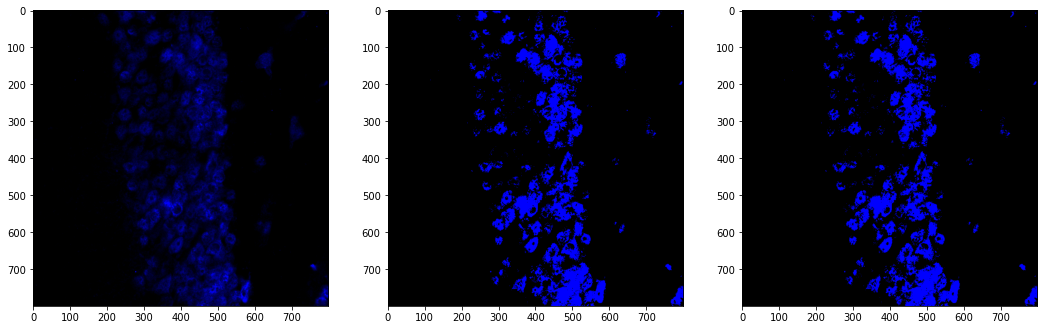

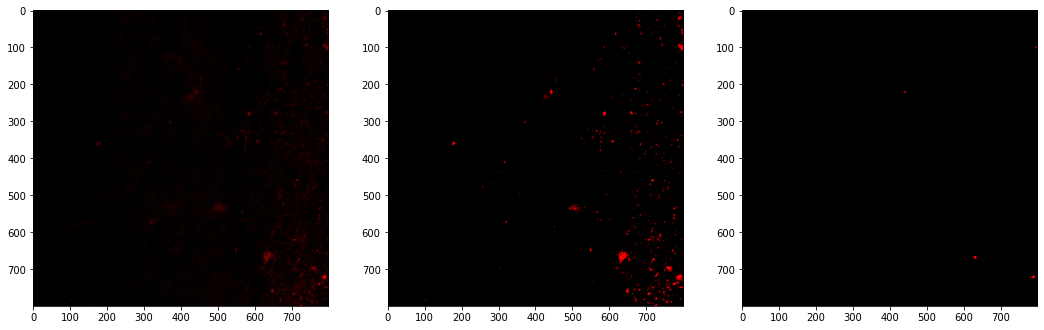

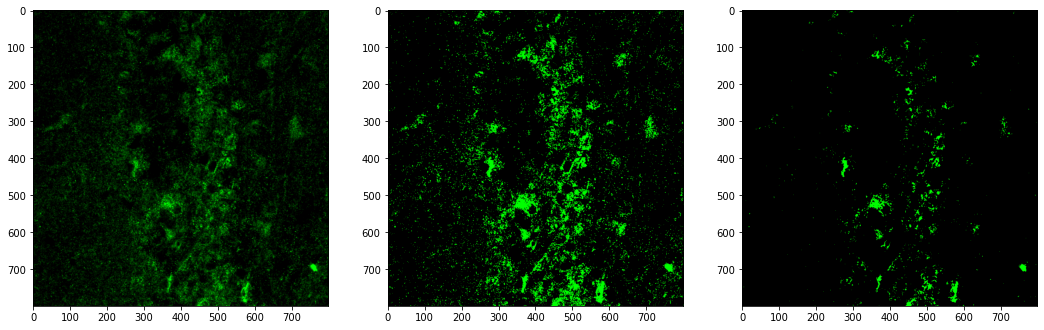

In [49]:
### threhold neun
zi = 0
zero_log = 1



image_c2 = image[:,:,2,:]

c2_vals = image_c2.flatten()
neu_thresh = filters.threshold_otsu(c2_vals)
neu_mask = image_c2>neu_thresh
neu_mask_b = filters.gaussian(neu_mask,.1)>0.8

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c2[:,:,zi],cmap=blue_map)
ax[1].imshow(neu_mask[:,:,zi],cmap=blue_map)
ax[2].imshow(neu_mask_b[:,:,zi],cmap=blue_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## Red Mask
image_c1 = image[:,:,1,:]
# image_c1 = filters.gaussian(image_c1,2)
c1_vals = image_c1.flatten()
mcher_thresh = filters.threshold_otsu(np.log(c1_vals+zero_log))
mcher_mask = image_c1>(filters.threshold_otsu(c1_vals))
# mcher_mask = np.log(image_c1+zero_log)>mcher_thresh*1
mcher_mask_b = filters.gaussian(mcher_mask,2)>0.8

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c1[:,:,zi],cmap=red_map)
ax[1].imshow(mcher_mask[:,:,zi],cmap=red_map)
ax[2].imshow(mcher_mask_b[:,:,zi],cmap=red_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## green Mask
image_c0 = image[:,:,0,:]
# image_c0 = filters.gaussian(image_c0,0)
c0_vals = image_c0.flatten()
# crisp_thresh = filters.threshold_otsu(np.log(c0_vals+zero_log))
crisp_mask = image_c0>(filters.threshold_otsu(c0_vals)*1)
# crisp_mask = np.log(image_c0+zero_log)>crisp_thresh*1
crisp_mask_b = filters.gaussian(crisp_mask,.4)>.99

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c0[:,:,zi],cmap=green_map)
ax[1].imshow(crisp_mask[:,:,zi],cmap=green_map)
ax[2].imshow(crisp_mask_b[:,:,zi],cmap=green_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)
plt.show()

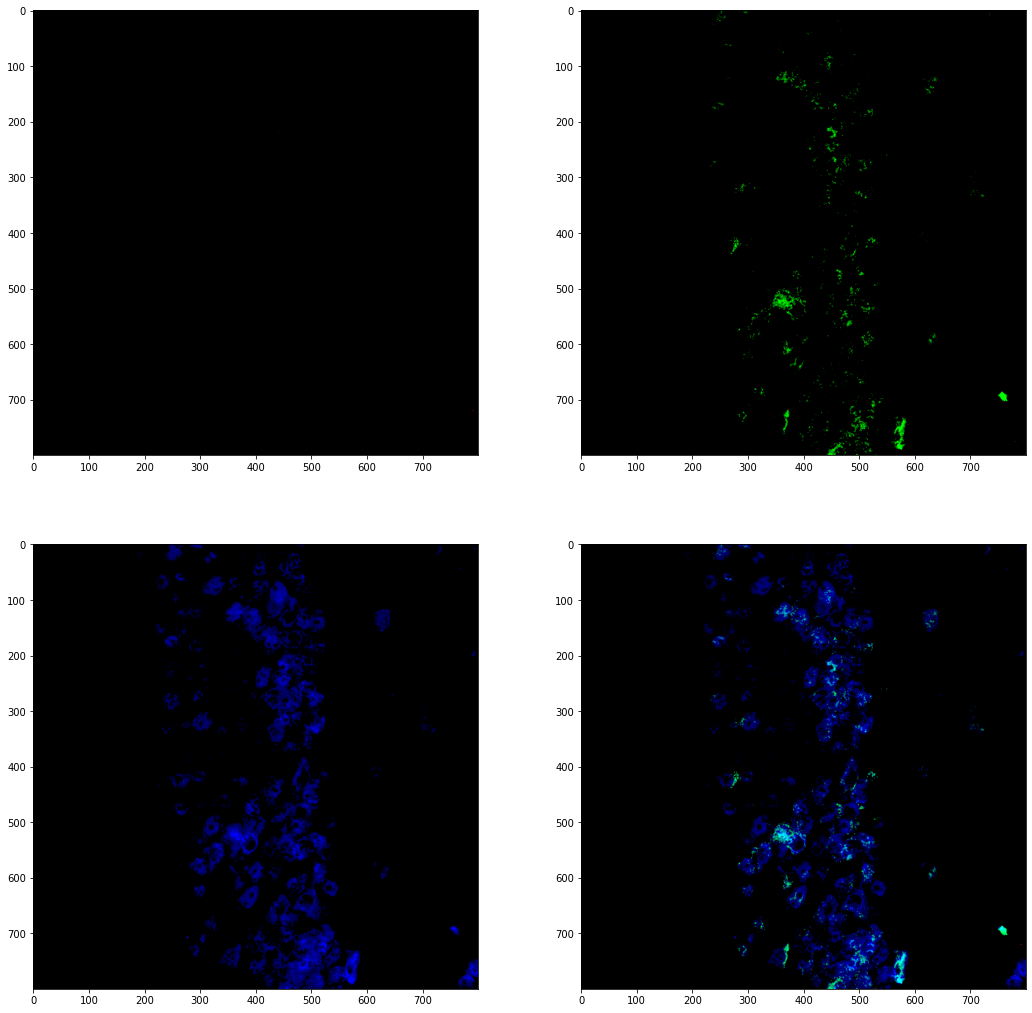

In [50]:
fig,ax = plt.subplots(2,2,figsize=[18,18])
ax = ax.flatten()
red_chan = mcher_mask_b*image[:,:,1]
red_chan = red_chan/np.max(red_chan.flatten())*neu_mask_b
green_chan = crisp_mask_b*image[:,:,0]
green_chan = green_chan/np.max(green_chan.flatten())*neu_mask_b
blue_chan = neu_mask_b*image[:,:,2]
blue_chan = blue_chan/np.max(blue_chan.flatten())*1
zi = 0
composite = np.stack([red_chan,green_chan,blue_chan],axis=-2)*1.0


ax[0].imshow(red_chan[:,:,zi],cmap=red_map)
ax[1].imshow(green_chan[:,:,zi],cmap=green_map)
ax[2].imshow(blue_chan[:,:,zi],cmap=blue_map)
ax[3].imshow(composite[:,:,:,zi])
plt.show()

In [51]:
# alexa-488
# 594
# 647

In [52]:
neu_mask_flat = neu_mask_b.flatten()
red_vals = red_chan.flatten()
green_vals = green_chan.flatten()

red_pix_in_cell = red_vals[neu_mask_flat]
green_pix_in_cell = green_vals[neu_mask_flat]

rpos_gpos = np.logical_and(red_pix_in_cell,green_pix_in_cell)
rpos_gneg = np.logical_and(red_pix_in_cell,np.logical_not(green_pix_in_cell))
rneg_gpos = np.logical_and(np.logical_not(red_pix_in_cell),green_pix_in_cell)
rneg_gneg = np.logical_and(np.logical_not(red_pix_in_cell),np.logical_not(green_pix_in_cell))


# rpos_gpos_count = np.sum(rpos_gpos)
# rpos_gneg_count = np.sum(rpos_gneg)
# rneg_gpos_count = np.sum(rneg_gpos)
# rneg_gneg_count = np.sum(rneg_gneg)



print('rpos_gpos',np.sum(rpos_gpos) )
print('rpos_gneg',np.sum(rpos_gneg) )
print('rneg_gpos',np.sum(rneg_gpos) )
print('rneg_gneg',np.sum(rneg_gneg) )
print('')

print('P(G+|R+) ',  np.round(np.sum(rpos_gpos) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )
print('P(G-|R+) ',  np.round(np.sum(rpos_gneg) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )

print('P(G+|R-) ',  np.round(np.sum(rneg_gpos) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('P(G-|R-) ',  np.round(np.sum(rneg_gneg) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('')

# print('P(G+) ', np.round(np.mean(green_pix_in_cell)*100,1))
# print('P(G-) ',  np.round(100-np.mean(green_pix_in_cell)*100,1))
# print('P(R+) ',  np.round(np.mean(red_pix_in_cell)*100,1))
# print('P(R-) ',  np.round(100-np.mean(red_pix_in_cell)*100,1))


# import scipy
# table = [[np.sum(rpos_gneg),np.sum(rpos_gpos)],[np.sum(rneg_gneg),np.sum(rneg_gpos)] ]
# odds_ratio, p_val = scipy.stats.fisher_exact(table, alternative='two-sided')
# print('p=',p_val)

rpos_gpos 97
rpos_gneg 189
rneg_gpos 104728
rneg_gneg 584852

P(G+|R+)  33.9
P(G-|R+)  66.1
P(G+|R-)  15.2
P(G-|R-)  84.8

